https://www.kaggle.com/code/alaawaelmo/youtube-comments-spam-detection/notebook#Import-Libraries

Dataset: https://github.com/mansipatel12/CS6348Project/blob/main/modified_spam.csv


In [ ]:
# Added these to dataset while training

    # "Win a free iPhone now! Click here: http://scam.com/win",
    # "Congratulations! You've won a gift card: http://fakepromo.com/gift",
    # "Hurry! Claim your prize before it expires: http://phishingsite.com/prize",
    # "Get rich quick! Learn how: http://fraudsite.com/make-money",
    # "You've been selected for a free vacation! http://scamtravel.com/free-trip",
    # "Your account is compromised! Reset here: http://fakebank.com/reset",
    # "Exclusive deal just for you! http://spamsite.com/deal",
    # "Limited offer! Get 50% off: http://fakepromo.com/deal",
    # "Your PayPal needs verification: http://phishing.com/paypal",
    # "Earn $500 daily from home: http://spamjob.com/work-from-home",
    # "You've won a new car! Claim it here: http://carwin.com/claim",
    # "Unlock your exclusive discount: http://shadydeals.com/save",
    # "Get a free trial for our service: http://fakesite.com/trial",
    # "Special gift for you! Click now: http://giftcardscam.com",
    # "Your Netflix subscription is expiring! Update now: http://fakeflix.com/renew",
    # "Fast weight loss pills! See results now: http://spamhealth.com/lose-weight",
    # "You qualify for a free credit report: http://creditcheckscam.com",
    # "Someone is searching for you! Find out who: http://stalkercheck.com",
    # "Your Amazon order needs confirmation: http://fakeamazon.com/order",
    # "Investment opportunity! Make money fast: http://getrichquick.com",



    # "Hey, check out this article: https://news.com/latest-tech",
    # "Let's meet up later. Details at: https://meetup.com/event",
    # "I found a great tutorial here: https://learncode.com/python",
    # "This blog post is amazing: https://medium.com/tech-insights",
    # "Join our webinar on AI: https://webinarsite.com/ai-talk",
    # "New research paper published: https://arxiv.org/1234.5678",
    # "Check this documentary: https://netflix.com/documentary",
    # "Read this book review: https://bookreviews.com/great-reads",
    # "This online course is helpful: https://udemy.com/ml-course",
    # "Join our Slack community: https://slack.com/invite",
    # "Follow this coding tutorial: https://github.com/cool-repo",
    # "Watch this educational video: https://youtube.com/lesson123",
    # "Find the event details here: https://eventbrite.com/dev-con",
    # "New job listings available: https://indeed.com/jobs",
    # "Read today's breaking news: https://cnn.com/world-news",
    # "Free educational resources: https://coursera.org/free-courses",
    # "Download our mobile app: https://playstore.com/new-app",
    # "Discover new music playlists: https://spotify.com/hits",
    # "Check out this fun game: https://steam.com/popular-game",
    # "Weekend travel guide: https://tripadvisor.com/destinations"


# Removing few common stop words + With Oversampling + With GridSearch

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:


# Read the file manually, treating it as raw text
with open("/content/modified_spam.csv", "r", encoding="utf-8") as input_file:
    lines = input_file.readlines()

# Skip the header row
lines = lines[1:]

# Process each line by splitting at the first comma
dataset = []
for line in lines:
    # Split at the first comma only
    parts = line.strip().split(",", 1)
    # Ensure valid split
    if len(parts) == 2:
        dataset.append(parts)
    else:
        # Handle missing messages
        dataset.append([parts[0], ""])


In [38]:



# Create a dataframe with the dataset; create two columns for label and message
dataframe = pd.DataFrame(dataset, columns=["label", "message"])
# Map ham = 0 and spam = 1in the label
dataframe['label'] = dataframe['label'].map({'ham': 0, 'spam': 1})


In [39]:

# Drop rows that have NaN or inf as labels
 # Remove NaN values
dataframe = dataframe[~dataframe['label'].isna()]
# Remove inf laebls
dataframe = dataframe[~dataframe['label'].apply(np.isinf)]

dataframe['label'] = dataframe['label'].astype(int)


In [40]:
# Text cleaning function (without stopword removal - we'll let TF-IDF handle it)
def clean_text(text):
    # Keep numbers and some special characters that are spam indicators
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\$[\d,]+', ' money ', text)  # Preserve monetary amounts
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', ' number ', text)  # Replace numbers with placeholder
    text = re.sub(r'[\'\"\.,;:!?]', ' ', text)  # Remove punctuation but keep word separators
    text = re.sub(r'\s+', ' ', text).strip()
    return text




# Text cleaning function (without stopword removal - we'll let TF-IDF handle it)
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
#     text = re.sub(r'\@\w+|\#','', text)
#     text = re.sub(r'[^\w\s]','', text)
#     text = re.sub(r'\s+',' ', text).strip()
#     return text

In [41]:
dataframe['message'] = dataframe['message'].apply(clean_text)


In [42]:
x=dataframe['message']
y=dataframe['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


In [43]:
# Parameter grid for GridSearch
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__use_idf': [True, False],
    'clf__n_estimators': [100],
    'clf__max_depth': [None]
}



In [44]:
# Pipeline with SMOTE and TF-IDF using built-in stop words
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.8,
        use_idf=True,
        smooth_idf=True)),  # Using built-in English stop words
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('clf', RandomForestClassifier(random_state=42,class_weight='balanced'))
])

In [45]:
# GridSearch with F1-score optimization
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

In [46]:
print("Starting Grid Search...")
grid_search.fit(x_train, y_train)
print("Grid Search Complete!")

Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid Search Complete!


In [47]:
# # Mini test run (remove after testing)
# mini_param_grid = {
#     'tfidf__max_features': [5000],
#     'tfidf__ngram_range': [(1,1)],
#     'clf__n_estimators': [50],  # Fewer trees
#     'clf__max_depth': [None]
# }
# mini_search = GridSearchCV(pipeline, mini_param_grid, cv=3, n_jobs=-1)
# mini_search.fit(x_train[:1000], y_train[:1000])  # Small data subset



# classified everything as not spam

In [48]:
# Best model evaluation
best_model = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")


Best Parameters:
clf__max_depth: None
clf__n_estimators: 100
tfidf__max_features: 5000
tfidf__ngram_range: (1, 1)
tfidf__use_idf: True


In [49]:

# Evaluation
y_pred = best_model.predict(x_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       954
           1       0.98      0.84      0.90       169

    accuracy                           0.97      1123
   macro avg       0.98      0.92      0.94      1123
weighted avg       0.97      0.97      0.97      1123




Confusion Matrix:


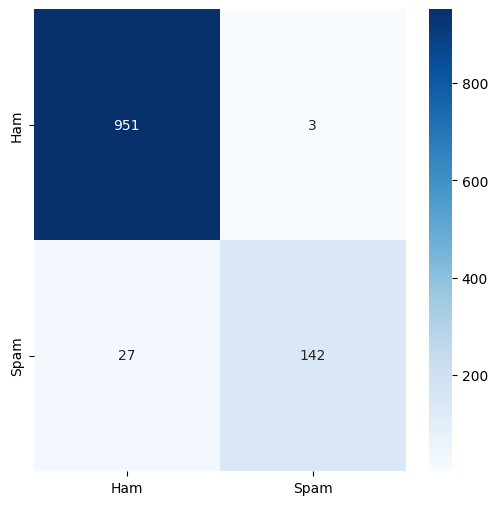

In [50]:
print("\nConfusion Matrix:")
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()


In [51]:
# Test on sample messages
test_msgs = [
    # "WINNER!! Claim your prize now! Text YES to 4455",
    # "Hey, can we reschedule for tomorrow?",
    # "URGENT: Your account needs verification",
    # "Lunch tomorrow at the usual place?",
    # "You were the randomly selected candidate click this link to find out more"


# Spam messages
    "URGENT: Your PayPal account has been locked! Click here to verify: bit.ly/paypal-secure-now",
    "You've won $5000 Walmart gift card! Reply YES to claim your prize 🎁",
    "Crypt0 0pportunity! Invest in Bitcoin now & 10X your money in 24hrs. Join here: crypto-scam.site",
    "Apple ID suspended - suspicious activity detected. Confirm your details: appl3-id-verify.com",
    "Your Netflix subscription expired. Update payment now to avoid interruption: netflix-payment-update.cc",
    "Fr33 iPh0n3 XV just 4 completing survey! Limited time: freestuff4u.win",
    "L0sers dont click! WINNERS get $$$ now at winnerz-only.xyz",
    "Hi mom, can you believe I won a free iPhone? Just had to pay $5 shipping! So excited!",
    "Your Amazon package couldn't be delivered. Reschedule here: amaz0n-delivery-reschedule.com",
    "Claim now!",
    "$$$",
    "¡Gane $1000 dólares ahora! Haga clic aquí",
    "🤑🤑🤑 MAKE MONEY FAST 🚀🚀🚀 Click now!",
    "❗URGENT❗ Your account ❗VERIFICATION❗ needed",
    "You have 1 unread message 555-1234 call now",
    "H0t sing1es in your area want 2 meet U! Chat now: lonely-harts.click",
    "Bank of America: Your debit card was used for $1,287 at Walmart. Call 800-555-0199 if not you",


    "Hey, are we still meeting for lunch tomorrow at 1pm?",
    "Can you pick up milk on your way home? We're all out.",
    "Running late - stuck in traffic. Be there in 20 mins.",
    "Your DoorDash order #48721 has been delivered",
    "Your doctor's appointment is confirmed for Thursday at 3:30pm",
    "United Airlines: Flight UA341 to Chicago is on time, departs at 6:15pm",
    "Following up on our meeting yesterday - attached are the revised project timelines",
    "The team meeting has been moved to Conference Room B",
    "Your job application at Google has been received and is under review",
    "FREE concert tickets for volunteers! Sign up at studentcenter.org",
    "You won teacher of the month! Come to the faculty lounge for your prize",
    "OK",
    "Let's meet at the café at 5",
    "The code is 58392 expires in 5 mins",
    "My new number is 415-555-0192",
    "Dinner was great! 😊👍🍕",
    "Bank fraud alert: Please call our verified number at 800-432-1000 if you see suspicious activity",
    "Did you get a chance to view this article? https://netflix.com/documentary"
]


In [52]:
for msg in test_msgs:
    clean_msg = clean_text(msg)
    proba = best_model.predict_proba([clean_msg])[0]
    print(f"\nMessage: {msg}")
    print(f"Prediction: {'SPAM' if best_model.predict([clean_msg])[0] else 'HAM'}")
    print(f"Confidence: {max(proba):.2%}")


Message: URGENT: Your PayPal account has been locked! Click here to verify: bit.ly/paypal-secure-now
Prediction: SPAM
Confidence: 84.00%

Message: You've won $5000 Walmart gift card! Reply YES to claim your prize 🎁
Prediction: SPAM
Confidence: 67.00%

Message: Crypt0 0pportunity! Invest in Bitcoin now & 10X your money in 24hrs. Join here: crypto-scam.site
Prediction: HAM
Confidence: 69.78%

Message: Apple ID suspended - suspicious activity detected. Confirm your details: appl3-id-verify.com
Prediction: SPAM
Confidence: 81.00%

Message: Your Netflix subscription expired. Update payment now to avoid interruption: netflix-payment-update.cc
Prediction: HAM
Confidence: 66.00%

Message: Fr33 iPh0n3 XV just 4 completing survey! Limited time: freestuff4u.win
Prediction: HAM
Confidence: 54.04%

Message: L0sers dont click! WINNERS get $$$ now at winnerz-only.xyz
Prediction: HAM
Confidence: 85.00%

Message: Hi mom, can you believe I won a free iPhone? Just had to pay $5 shipping! So excited!
Pre

In [53]:
spam_text=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]


not_spam_text=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]

In [54]:

spam_text=[clean_text(sent) for sent in spam_text ]
not_spam_text=[clean_text(sent) for sent in not_spam_text ]


In [55]:
spam_text


['i made money in one week you can too click here to find out how',
 'this is amazing check my page for similar content',
 'i love this sub for sub',
 '🔥🔥 this video is on fire check my channel too 🔥🔥']

In [56]:
not_spam_text


['i love eminem',
 'i think about number millions of the views come from people who only wanted to check the views',
 'psy - gangnam style( ) m/v thumbs up if u checked this video to see hw views it got\ufeff']

In [57]:
pred = best_model.predict(spam_text)
for i in range(len(spam_text)):
    if pred[i] < 0.5:
        print(f'Text: "{spam_text[i]}" \nPrediction: Not Spam\n')
    else:
        print(f'Text: "{spam_text[i]}" \nPrediction: Spam\n')


Text: "i made money in one week you can too click here to find out how" 
Prediction: Not Spam

Text: "this is amazing check my page for similar content" 
Prediction: Not Spam

Text: "i love this sub for sub" 
Prediction: Not Spam

Text: "🔥🔥 this video is on fire check my channel too 🔥🔥" 
Prediction: Not Spam



In [58]:

pred = best_model.predict(not_spam_text)
for i in range(len(not_spam_text)):
    if pred[i] < 0.5:
        print(f'Text: "{not_spam_text[i]}" \nPrediction: Not Spam\n')
    else:
        print(f'Text: "{not_spam_text[i]}" \nPrediction: Spam\n')

Text: "i love eminem" 
Prediction: Not Spam

Text: "i think about number millions of the views come from people who only wanted to check the views" 
Prediction: Not Spam

Text: "psy - gangnam style( ) m/v thumbs up if u checked this video to see hw views it got﻿" 
Prediction: Not Spam




Testing Accuracy: 97.33%

Classification Report:
              precision    recall  f1-score   support

         HAM       0.97      1.00      0.98       954
        SPAM       0.98      0.84      0.90       169

    accuracy                           0.97      1123
   macro avg       0.98      0.92      0.94      1123
weighted avg       0.97      0.97      0.97      1123



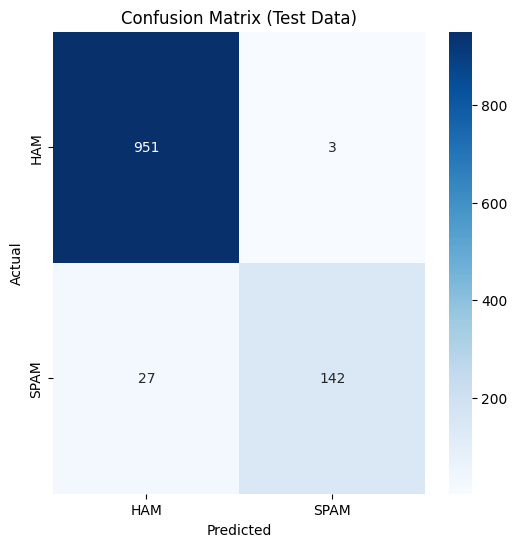

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test data
y_pred = best_model.predict(x_test)

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTesting Accuracy: {test_accuracy:.2%}")  # e.g., "95.23%"

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["HAM", "SPAM"]))

# Confusion Matrix (visual)
plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["HAM", "SPAM"],
    yticklabels=["HAM", "SPAM"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Data)")
plt.show()